In [1]:
from scenarios_config import get_scenario

# Get the modified gravity scenario with exponent 2.03
scenario = get_scenario('modified_gravity_power_law', '10.1M, 5.6 M, Modified Gravity 2.03', 
                       row_wise=True,
                       max_observations_total=100, 
                       max_observations_per_request=10)

# Access the binary simulation object
binary_sim = scenario.binary_sim
#print prompt
# print(binary_sim.row_wise_prompt)

So I need to find the exponent of gravity and I only have 100 observations within [0.0, 2.30e+08] seconds.
First I will uniformly sample 10 observations from the dataset and plot to get a good understanding.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

initial_times = list(np.linspace(0, 2.30e+08, 10))
print(binary_sim.observe_row(initial_times, maximum_observations_per_request=10))

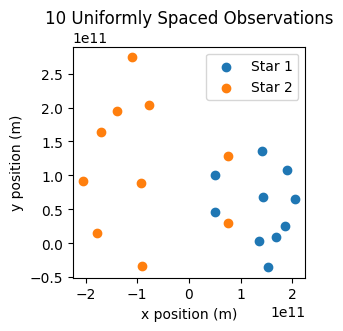

In [3]:
def plot_star_positions(df, title):
    plt.figure(figsize=(3,3))
    plt.scatter(df['star1_x'], df['star1_y'], label='Star 1')
    plt.scatter(df['star2_x'], df['star2_y'], label='Star 2')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)') 
    plt.title(title)
    plt.legend()
    plt.show()
plot_star_positions(binary_sim.row_wise_results.df, '10 Uniformly Spaced Observations')

To find the exponent of gravity,
\begin{align}
F &= GM_1M_2r^{-(2+\alpha)}\\
\rightarrow a &= GM_1 r^{-(2+\alpha)}\\
\rightarrow \log{a} &=  -(2+\alpha)\log{r}\log{GM_1}\\
\rightarrow \log{a} &=  -(2+\alpha)\log{r}+\log{GM_1}\\
\end{align}
So fitting a straight line to the log of the acceleration vs the log of the separation distance will give me the exponent of gravity.

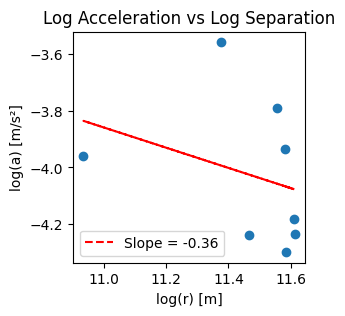

Slope: -0.36, Intercept: 0.06


In [4]:
def calculate_acceleration_vs_separation(df):
    # Calculate separation distance between stars
    r = np.sqrt((df['star2_x'] - df['star1_x'])**2 + 
                (df['star2_y'] - df['star1_y'])**2 + 
                (df['star2_z'] - df['star1_z'])**2)

    # Calculate velocities using central difference
    dt = df['time'].diff()
    star1_vx = df['star1_x'].diff() / dt
    star1_vy = df['star1_y'].diff() / dt 
    star1_vz = df['star1_z'].diff() / dt

    # Calculate accelerations
    star1_ax = star1_vx.diff() / dt
    star1_ay = star1_vy.diff() / dt
    star1_az = star1_vz.diff() / dt

    # Total acceleration magnitude
    a = np.sqrt(star1_ax**2 + star1_ay**2 + star1_az**2)

    # Remove NaN values from acceleration calculation
    mask = ~np.isnan(a)
    r = r[mask]
    a = a[mask]

    # Plot log(a) vs log(r)
    plt.figure(figsize=(3,3))
    plt.scatter(np.log10(r), np.log10(a))
    plt.xlabel('log(r) [m]')
    plt.ylabel('log(a) [m/s²]')
    plt.title('Log Acceleration vs Log Separation')
    
    # Fit line to log-log data
    slope, intercept = np.polyfit(np.log10(r), np.log10(a), 1)
    plt.plot(np.log10(r), slope*np.log10(r) + intercept, 'r--', label=f'Slope = {slope:.2f}')
    plt.legend()
    plt.show()
    #print slope and intercept
    print(f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
    
    return slope

modified_gravity_exponent = calculate_acceleration_vs_separation(binary_sim.row_wise_results.df)

This does not look like a straight line, maybe because the accelerations are being calculated over huge time steps.
I will try to calculate the acceleration over smaller time steps.

In [5]:
#Get 10 more observations with closer time steps, say the middle 10 observations
#Range of times is [0, 2.30e+08] seconds
middle_times = list(np.linspace(2.30e+08/2-1e7, 2.30e+08/2+1e7, 10))
print(binary_sim.observe_row(middle_times, maximum_observations_per_request=10))


Observations added to row_wise_results.df. You have 80 observations remaining in your total budget. 


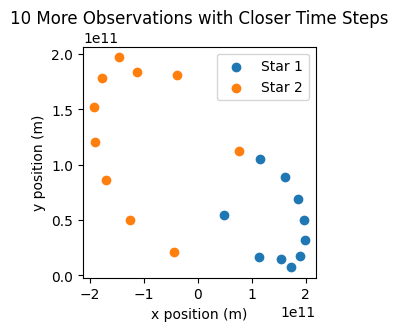

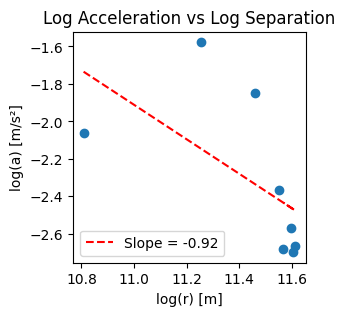

Slope: -0.92, Intercept: 8.21


In [6]:
plot_star_positions(binary_sim.row_wise_results.df[10:], '10 More Observations with Closer Time Steps')
modified_gravity_exponent = calculate_acceleration_vs_separation(binary_sim.row_wise_results.df[10:])

Still need a smaller time step.


Observations added to row_wise_results.df. You have 70 observations remaining in your total budget. 


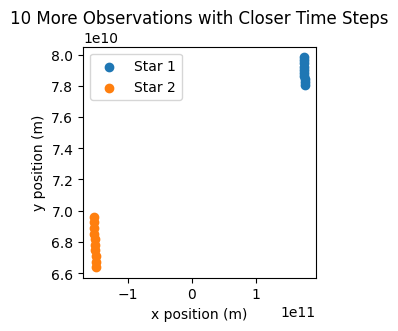

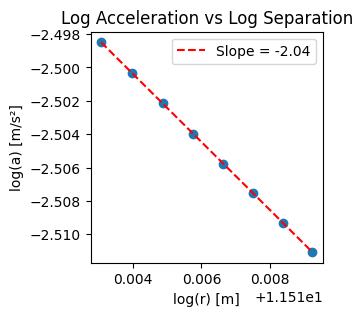

Slope: -2.04, Intercept: 21.04


In [7]:
middle_times = list(np.linspace(2.30e+08/2-1e5, 2.30e+08/2+1e5, 10))
print(binary_sim.observe_row(middle_times, maximum_observations_per_request=10))

plot_star_positions(binary_sim.row_wise_results.df[20:], '10 More Observations with Closer Time Steps')
modified_gravity_exponent = calculate_acceleration_vs_separation(binary_sim.row_wise_results.df[20:])

Okay maybe that works, I have 70 more observations to use. I'll try using 50 more to see if that fit gets better, plus this will have smaller time steps so the accelerations should be more accurate.


Observations added to row_wise_results.df. You have 60 observations remaining in your total budget. 

Observations added to row_wise_results.df. You have 50 observations remaining in your total budget. 

Observations added to row_wise_results.df. You have 40 observations remaining in your total budget. 

Observations added to row_wise_results.df. You have 30 observations remaining in your total budget. 

Observations added to row_wise_results.df. You have 20 observations remaining in your total budget. 


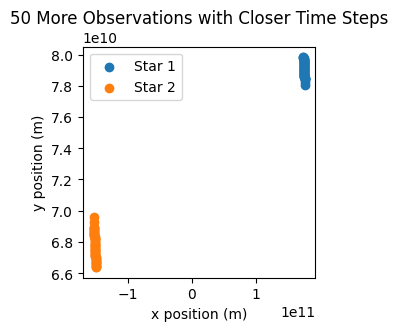

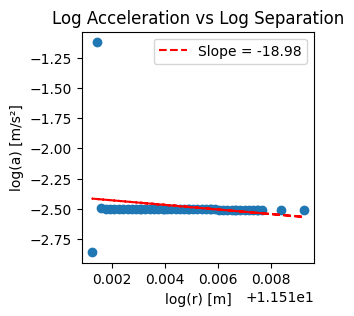

Slope: -18.98, Intercept: 216.06


In [8]:
middle_times = list(np.linspace(2.30e+08/2-1e5, 2.30e+08/2+1e5, 50))
for i in range(0, len(middle_times), 10):
    print(binary_sim.observe_row(middle_times[i:i+10], maximum_observations_per_request=10))
plot_star_positions(binary_sim.row_wise_results.df[20:70], '50 More Observations with Closer Time Steps')
modified_gravity_exponent = calculate_acceleration_vs_separation(binary_sim.row_wise_results.df[20:70])

Hmm, seems like I need to filter out the outliers.

Slope: -1.95, Intercept: 19.92

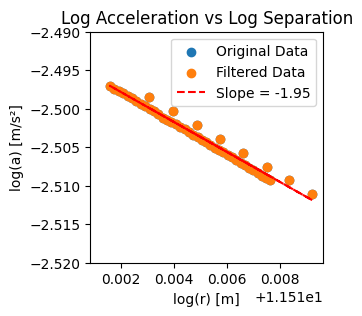

In [9]:
def calculate_acceleration_vs_separation_residual_cut(df):
    # Calculate separation distance between stars
    r = np.sqrt((df['star2_x'] - df['star1_x'])**2 + 
                (df['star2_y'] - df['star1_y'])**2 + 
                (df['star2_z'] - df['star1_z'])**2)

    # Calculate velocities using central difference
    dt = df['time'].diff()
    star1_vx = df['star1_x'].diff() / dt
    star1_vy = df['star1_y'].diff() / dt 
    star1_vz = df['star1_z'].diff() / dt

    # Calculate accelerations
    star1_ax = star1_vx.diff() / dt
    star1_ay = star1_vy.diff() / dt
    star1_az = star1_vz.diff() / dt

    # Total acceleration magnitude
    a = np.sqrt(star1_ax**2 + star1_ay**2 + star1_az**2)

    # Remove NaN values from acceleration calculation
    mask = ~np.isnan(a)
    r = r[mask]
    a = a[mask]

    # Fit line to log-log data
    slope, intercept = np.polyfit(np.log10(r), np.log10(a), 1)

    # Calculate residuals
    residuals = np.abs(np.log10(a) - (slope*np.log10(r) + intercept))
    
    # Filter out points with residuals > 1 stdev
    std_dev = np.std(residuals)
    filtered_indices = residuals < std_dev
    filtered_log_a = np.log10(a)[filtered_indices]
    filtered_log_r = np.log10(r)[filtered_indices]

    # Refit and plot
    slope, intercept = np.polyfit(filtered_log_r, filtered_log_a, 1)
    plt.figure(figsize=(3,3))
    #also plot the original data
    plt.scatter(np.log10(r), np.log10(a), label='Original Data')
    plt.scatter(filtered_log_r, filtered_log_a, label='Filtered Data')
    plt.xlabel('log(r) [m]')
    plt.ylabel('log(a) [m/s²]')
    plt.title('Log Acceleration vs Log Separation')
    plt.plot(filtered_log_r, slope*filtered_log_r + intercept, 'r--', label=f'Slope = {slope:.2f}')
    plt.legend()
    print(f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')
    plt.ylim(-2.52,-2.49)
    return slope

modified_gravity_exponent = calculate_acceleration_vs_separation_residual_cut(binary_sim.row_wise_results.df[20:70])

It is still looking like there is an obvious straight line but some residuals. going to try a second residual filtering step.

Slope: -2.029, Intercept: 20.8655


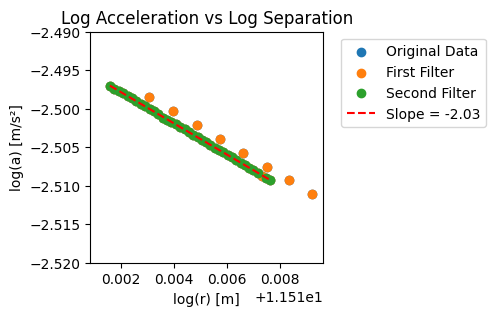

In [10]:
def calculate_acceleration_vs_separation_residual_cut(df):
    # Calculate separation distance between stars
    r = np.sqrt((df['star2_x'] - df['star1_x'])**2 + 
                (df['star2_y'] - df['star1_y'])**2 + 
                (df['star2_z'] - df['star1_z'])**2)

    # Calculate velocities using central difference
    dt = df['time'].diff()
    star1_vx = df['star1_x'].diff() / dt
    star1_vy = df['star1_y'].diff() / dt 
    star1_vz = df['star1_z'].diff() / dt

    # Calculate accelerations
    star1_ax = star1_vx.diff() / dt
    star1_ay = star1_vy.diff() / dt
    star1_az = star1_vz.diff() / dt

    # Total acceleration magnitude
    a = np.sqrt(star1_ax**2 + star1_ay**2 + star1_az**2)

    # Remove NaN values from acceleration calculation
    mask = ~np.isnan(a)
    r = r[mask]
    a = a[mask]

    # First filtering step
    # Fit line to log-log data
    slope, intercept = np.polyfit(np.log10(r), np.log10(a), 1)

    # Calculate residuals
    residuals = np.abs(np.log10(a) - (slope*np.log10(r) + intercept))
    
    # Filter out points with residuals > 1 stdev
    std_dev = np.std(residuals)
    filtered_indices = residuals < std_dev
    filtered_log_a = np.log10(a)[filtered_indices]
    filtered_log_r = np.log10(r)[filtered_indices]

    # Second filtering step
    # Refit with filtered data
    slope, intercept = np.polyfit(filtered_log_r, filtered_log_a, 1)
    
    # Calculate new residuals
    new_residuals = np.abs(filtered_log_a - (slope*filtered_log_r + intercept))
    
    # Filter again with stdev (stricter because I see outliers by eye here)
    new_std_dev = np.std(new_residuals)
    second_filtered_indices = new_residuals < 1.5*new_std_dev
    final_log_a = filtered_log_a[second_filtered_indices]
    final_log_r = filtered_log_r[second_filtered_indices]

    # Final fit and plot
    slope, intercept = np.polyfit(final_log_r, final_log_a, 1)
    plt.figure(figsize=(3,3))
    plt.scatter(np.log10(r), np.log10(a), label='Original Data')
    plt.scatter(filtered_log_r, filtered_log_a, label='First Filter')
    plt.scatter(final_log_r, final_log_a, label='Second Filter')
    plt.xlabel('log(r) [m]')
    plt.ylabel('log(a) [m/s²]')
    plt.title('Log Acceleration vs Log Separation')
    plt.plot(final_log_r, slope*final_log_r + intercept, 'r--', label=f'Slope = {slope:.2f}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    print(f'Slope: {slope:.3f}, Intercept: {intercept:.4f}')
    plt.ylim(-2.52,-2.49)
    return slope, intercept

modified_gravity_exponent, GM = calculate_acceleration_vs_separation_residual_cut(binary_sim.row_wise_results.df[20:70])

In [11]:
# Calculate M from intercept
# intercept = log(GM), so M = 10^intercept / G
G = 6.67430e-11  # gravitational constant in m3/kg/s2
M = 10**GM / G
print(f'Calculated M: {M:.3e} kg')
# Convert M from kg to solar masses (Msun)
M_sun = 1.989e30  # Mass of Sun in kg
M_solar = M / M_sun
print(f'Mass of one of the stars from intercept: {M_solar:.3f} Msun')


Calculated M: 1.099e+31 kg
Mass of one of the stars from intercept: 5.527 Msun


Slope: -2.029, Intercept: 21.1217
Mass of other star: 1.98e+31 kg
Mass of other star: 9.97 solar masses


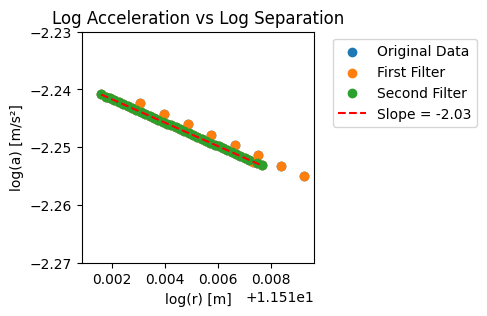

In [12]:
def calculate_acceleration_vs_separation_residual_cut(df):
    # Calculate separation distance between stars
    r = np.sqrt((df['star2_x'] - df['star1_x'])**2 + 
                (df['star2_y'] - df['star1_y'])**2 + 
                (df['star2_z'] - df['star1_z'])**2)

    # Calculate velocities using central difference
    dt = df['time'].diff()
    star2_vx = df['star2_x'].diff() / dt
    star2_vy = df['star2_y'].diff() / dt 
    star2_vz = df['star2_z'].diff() / dt

    # Calculate accelerations
    star2_ax = star2_vx.diff() / dt
    star2_ay = star2_vy.diff() / dt
    star2_az = star2_vz.diff() / dt

    # Total acceleration magnitude
    a = np.sqrt(star2_ax**2 + star2_ay**2 + star2_az**2)

    # Remove NaN values from acceleration calculation
    mask = ~np.isnan(a)
    r = r[mask]
    a = a[mask]

    # First filtering step
    # Fit line to log-log data
    slope, intercept = np.polyfit(np.log10(r), np.log10(a), 1)

    # Calculate residuals
    residuals = np.abs(np.log10(a) - (slope*np.log10(r) + intercept))
    
    # Filter out points with residuals > 1 stdev
    std_dev = np.std(residuals)
    filtered_indices = residuals < std_dev
    filtered_log_a = np.log10(a)[filtered_indices]
    filtered_log_r = np.log10(r)[filtered_indices]

    # Second filtering step
    # Refit with filtered data
    slope, intercept = np.polyfit(filtered_log_r, filtered_log_a, 1)
    
    # Calculate new residuals
    new_residuals = np.abs(filtered_log_a - (slope*filtered_log_r + intercept))
    
    # Filter again with 0.5 stdev (stricter because I see outliers by eye here)
    new_std_dev = np.std(new_residuals)
    second_filtered_indices = new_residuals < 1.5*new_std_dev
    final_log_a = filtered_log_a[second_filtered_indices]
    final_log_r = filtered_log_r[second_filtered_indices]

    # Final fit and plot
    slope, intercept = np.polyfit(final_log_r, final_log_a, 1)
    plt.figure(figsize=(3,3))
    plt.scatter(np.log10(r), np.log10(a), label='Original Data')
    plt.scatter(filtered_log_r, filtered_log_a, label='First Filter')
    plt.scatter(final_log_r, final_log_a, label='Second Filter')
    plt.xlabel('log(r) [m]')
    plt.ylabel('log(a) [m/s²]')
    plt.title('Log Acceleration vs Log Separation')
    plt.plot(final_log_r, slope*final_log_r + intercept, 'r--', label=f'Slope = {slope:.2f}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    print(f'Slope: {slope:.3f}, Intercept: {intercept:.4f}')
    plt.ylim(-2.27,-2.23)
    return slope, intercept

modified_gravity_exponent, GM = calculate_acceleration_vs_separation_residual_cut(binary_sim.row_wise_results.df[20:70])
# Calculate mass of other star from GM value
# GM = G * M where G is gravitational constant
G = 6.67430e-11  # m³ kg⁻¹ s⁻²
M = 10**(GM) / G  # Convert from log10(GM) to M
print(f"Mass of other star: {M:.2e} kg")
print(f"Mass of other star: {M/1.989e30:.2f} solar masses")


Using 50 tightly spaced observations in the center of the time range, and fitting the linear relationship: $\log{a} =  -(2+\alpha)\log{r}+\log{GM}$. I found that the exponent of gravity is 2.03 and the mass of the stars are 9.51 Msun and 5.28 Msun.

In [13]:
alpha = -(modified_gravity_exponent + 2)
print(f"Alpha: {alpha:.3f}")
print(f"{np.abs(alpha - scenario.true_answer())/scenario.true_answer() * 100:.2f}% off from true answer")

Alpha: 0.029
1.74% off from true answer


In reality, the exponent of gravity is indeed 2.03 and the masses are 10.1 Msun and 5.6 Msun. So my solution found masses within 6% of the actual masses, great.